# Demand Neural Network and Revenue Optimization

Yudi Wang 

Computational Science & Engineering, Harvard University


In [1]:
#import libraries and packages
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
#translate from the matlab code
import xlrd
import pandas as pd

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from keras.models import Sequential
from keras.layers import Dense, Activation

#translate from the matlab code
import xlrd
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#reading and setting data
NumSKU=49
NumVar=13
ID=[1138263,1139362,1139363,1141061,1142731,1143640,1144140,
        1148001,1148010,1148081,1162466,1162467,1162557,1162558,
        1162559,1163152,1163153,1164313,1164961,1164962,1165757,
        1166153,1166984,1166998,1167021,1167087,1167847,1167918,
        1170236,1170372,1170739,1173299,1174241,1174242,1174243,
        1174244,1174275,1174293,1174299,1174313,1174314,1174315,
        1174339,1174340,1175687,1175833,1175835,1175950,1177151]

#train data
new_tv_info = pd.read_excel('C:/Users/wyd15/Downloads/Television.xlsx', sheet_name='new_tv_info') #processed by matlab
tv_sim = pd.read_excel('Television.xlsx', sheet_name='Similarity')
#tv_sim.head()

In [3]:
#reorder
cols = list(new_tv_info)
#print(cols)
#cols.insert(3, cols.pop(cols.index('Price'))) #changed price locations
cols = ['ID', 'Date', 'SalesQuantity', 'Price', 'SalesQuantityLag1', 'SalesQuantityLag7', 'SalesQuantityLag14', 
        'Discount', 'InventoryAvailability', 'WeekOfYear', 'SpecialDayDummy', 'MinofComp', 'MinofComp1', 'Var14', 
        'Var15', 'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var21', 'Var22', 'Var23', 'Var24', 'Var25', 'Var26', 
        'Var27', 'Var28', 'Var29', 'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var35', 'Var36', 'Var37', 'Var38', 
        'Var39', 'Var40', 'Var41', 'Var42', 'Var43', 'Var44', 'Var45', 'Var46', 'Var47', 'Var48', 'Var49', 'Var50', 
        'Var51', 'Var52', 'Var53', 'Var54', 'Var55', 'Var56', 'Var57', 'Var58', 'Var59', 'Var60', 'Var61', 'Var62', 
        'Var63', 'Var64', 'Var65', 'Var66', 'Var67', 'Var69', 'Var71', 'Var73', 'Var75','Var77', 'Var79', 'Var81', 
        'Var83', 'Var68', 'Var70', 'Var72', 'Var74', 'Var76', 'Var78', 'Var80',  'Var82', 'Var84']

new_tv_info = new_tv_info.loc[:, cols]
new_tv_info.to_csv('tv_reorg.csv')

In [4]:
new_tv_info = pd.read_csv('tv_reorg.csv')
new_tv_info = new_tv_info.iloc[:, 1:]
new_tv_info.head()

,ID,Date,SalesQuantity,Price,SalesQuantityLag1,SalesQuantityLag7,SalesQuantityLag14,Discount,InventoryAvailability,WeekOfYear,...,Var83,Var68,Var70,Var72,Var74,Var76,Var78,Var80,Var82,Var84
0,1,2016-01-01,2,2626.27000,1,1,1,1.01,0.93,1,...,1753.387550,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
1,1,2016-01-02,6,2651.69398,2,1,1,1.01,0.93,1,...,1842.372600,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
2,1,2016-01-03,5,2774.57500,6,1,1,1.01,0.93,1,...,1789.243869,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
3,1,2016-01-04,6,2795.76000,5,1,1,1.01,0.93,2,...,1905.935100,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
4,1,2016-01-05,2,2795.76000,6,1,1,1.01,0.93,2,...,1905.925200,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01


In [5]:
#new_tv_info.iloc[:, 66:75] #all the prices

# Training demand neural network

In [13]:
beta=0.0001 #0.0001
alpha= 0.112 #learning_rate 0.112

tf.reset_default_graph()
x1=tf.placeholder(shape=(None, 18), dtype=tf.float32)
x2=tf.placeholder(shape=(None, 61), dtype=tf.float32)
y =tf.placeholder(shape=(None, ), dtype=tf.float32)

#
W1_1 = tf.get_variable('W1_1', shape=(18, 79))
W1_2 = tf.get_variable('W1_2', shape=(61, 79))
b1 = tf.get_variable('b1', shape=(1, 79))
    
o1_1 = tf.matmul(x1, W1_1)
o1_2 = tf.matmul(x2, W1_2)
o1 = o1_1 + o1_2 + b1
o1 = tf.nn.sigmoid(o1)
W2_1 = tf.get_variable('W2_1', shape=(61, 1))
W2_2 = tf.get_variable('W2_2', shape=(79, 1))
b2 = tf.get_variable('b2', shape=(1, 1))

o2_1 = tf.matmul(x2, W2_1)
o2_2 = tf.matmul(o1, W2_2)
o2 = o2_1 + o2_2 + b2
o2 = tf.reshape(o2, (-1, ))
saver = tf.train.Saver([W1_1, W1_2, b1, W2_1, W2_2, b2])

#add regularization on all the variables 
loss = tf.losses.mean_squared_error(y, o2)
#loss = tf.losses.cosine_distance(y, o2, axis=0)
train_var  = tf.trainable_variables() 
#add l2 regularization exclude all the bias
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in train_var if 'b' not in v.name ]) * beta #
#loss with regularization
loss= tf.reduce_mean(tf.losses.mean_squared_error(y, o2)+lossL2) 

optimizer = tf.train.AdamOptimizer(learning_rate=0.11) #tuned learning_rate
train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())

#train-test_split
msk = np.random.rand(len(new_tv_info)) < 0.85 #train_test split
tv_train = new_tv_info[msk]
tv_test = new_tv_info[~msk]
batch_size=50

train_losses=[]
test_losses=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(419):
        x1_train = tv_train.iloc[step*batch_size:step*batch_size+batch_size, 66:84].values 
        x2_train = np.concatenate((tv_train.iloc[step*batch_size:step*batch_size+batch_size, 3:11].values, tv_train.iloc[step*batch_size:step*batch_size+batch_size, 14:67].values), 1) 
        y_train = tv_train.iloc[step*batch_size:step*batch_size+batch_size, 2].values 
            
        x1_test = tv_test.iloc[:, 66:84].values 
        x2_test = np.concatenate((tv_test.iloc[:, 3:11].values, tv_test.iloc[:, 14:67].values), 1) 
        y_test = tv_test.iloc[:, 2].values 
            
        _train_loss, _ = sess.run([loss, train_op],feed_dict={x1: x1_train,
                                              x2: x2_train,
                                              y: y_train})
       
            
        _test_loss = sess.run([loss],feed_dict={x1: x1_test,
                                              x2: x2_test,
                                              y: y_test})
        train_losses.append( _train_loss)
        test_losses.append( _test_loss[0])
        # predict
        D_predict = sess.run([o2], feed_dict={x1:x1_test,x2:x2_test})
        para_pred = sess.run([W1_1, W1_2, b1, W2_1, W2_2, b2], feed_dict={x1:x1_test,x2:x2_test})
        #results, _ = sess.run([output]) #print parameters, W1_1 etc..
            
        if step % 100==0:
            saver.save(sess, 'C:/Users/wyd15/Desktop/tv_model/tv_modelslack.ckpt', global_step=step)
            print("iter:%d, train_loss: %f, test_loss: %f"%(step, _train_loss,  _test_loss[0]))
            #print('test prediction parameters results:', D_predict)
            #print('predicted parameters:', para_pred)
    print('\n last test prediction parameters results:', step, _train_loss,  _test_loss[0], '\n predicted test demand', y_test,'\n', D_predict)
    train_losses.append( _train_loss)
    test_losses.append( _test_loss[0])
    paras=para_pred
                #print('output:', )

iter:0, train_loss: 200504.796875, test_loss: 53661.902344
iter:100, train_loss: 302.791107, test_loss: 706.038086
iter:200, train_loss: 392.918274, test_loss: 107.792702
iter:300, train_loss: 106.627808, test_loss: 47.928097
iter:400, train_loss: 88.014557, test_loss: 37.598598

 last test prediction parameters results: 418 0.034908 54.7506 
 predicted test demand [ 5  5  7 ..., 25 24  5] 
 [array([ -4.37097359,  -2.34099054,   0.3755976 , ...,   1.90427887,
        17.76022339,   3.39142799], dtype=float32)]


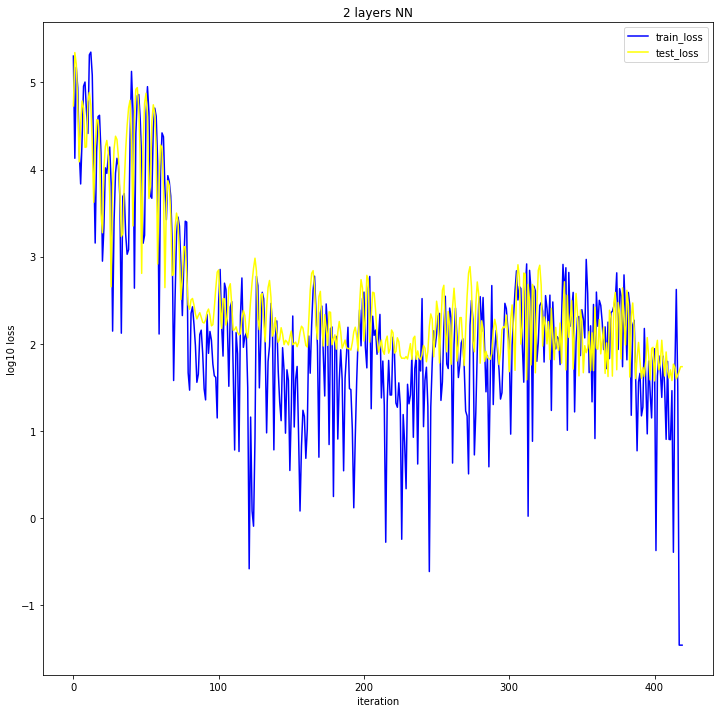

In [19]:
fig = plt.figure(figsize=(12, 12))
plt.title('2 layers NN')
plt.xlabel('iteration')
plt.ylabel('log10 loss')
plt.plot(np.log10(train_losses),color = 'blue', label='train_loss')
plt.plot(np.log10(test_losses), color= 'yellow', label='test_loss' )
plt.legend()
plt.show()

# Parameters for TV NN

In [5]:
import numpy as np
np.set_printoptions(threshold=1500)
import pickle
para_names=['W1_1', 'W1_2', 'b1', 'W2_1', 'W2_2', 'b2']
for i in range(len(para_names)):
    print(' ===== printing paramter: '+ para_names[i] +' ===== ')
    print(para_pred[i])

 ===== printing paramter: W1_1 ===== 
[[  5.10159552e-01  -5.60055196e-01  -5.71182251e-01   5.58091700e-01
   -5.86390734e-01  -5.39967120e-01  -4.66522366e-01  -2.43708193e-01
   -2.36894131e-01  -7.19668269e-01  -5.42470992e-01  -5.74124157e-01
    4.14336622e-01   5.86916208e-01  -6.40039325e-01   5.35342932e-01
   -5.18492699e-01  -5.75787127e-01  -5.32501340e-01   6.68643415e-01
    4.99356449e-01  -1.14664781e+00   5.12747407e-01   6.59732614e-04
    6.06913447e-01   6.48585260e-01   5.57623267e-01  -2.84736395e-01
   -5.72863877e-01  -4.94941980e-01  -1.03350461e+00   5.97277403e-01
   -6.84463739e-01  -6.36129856e-01  -4.76181954e-01   7.25725651e-01
   -6.06885433e-01  -5.86100340e-01  -5.67891777e-01   7.20831573e-01
   -6.08471632e-01  -4.87495422e-01  -1.07454491e+00  -5.69918990e-01
    5.11958480e-01   5.34504533e-01   8.31178248e-01   6.27393723e-01
    5.61331809e-01   5.62491775e-01   7.46560335e-01  -5.15101254e-01
   -5.31714916e-01   1.90579724e+00   6.37645721e-01

# Optimization nn for focal product price

simulation note:
- ignored constant vector for the optimization, i.e. set as zero vector
- only optimize over one focal product price

## training using NN

In [23]:
import time 

#optimize the loss funciton by adding negative sign
start_time= time.time()
tf.reset_default_graph()
p_f = tf.get_variable('p_f', shape=(1, 1)) #corresponding index 0 in 
W1_1 = tf.constant(paras[0], dtype=tf.float32, name='W1_1' )
W1_2_1 = tf.constant(paras[1][0, :], dtype=tf.float32, shape=[1, 79], name='W1_2_1')
W1_2_2 = tf.constant(paras[1][1:, :], dtype=tf.float32, name='W1_2_2')
b1 = tf.constant(paras[2], dtype=tf.float32, name='b1' )
W2_1_1 = tf.constant(paras[3][0, :], dtype=tf.float32, shape=[1, 1], name='W2_1_1')
W2_1_2 = tf.constant(paras[3][1:, :], dtype=tf.float32, name='W2_1_2')
W2_2 = tf.constant(paras[4], dtype=tf.float32, name='W2_2' )
b2 = tf.constant(paras[5], dtype=tf.float32, name='b2' )
p_sub =  tf.placeholder(shape=(None, 18), dtype=tf.float32)
p_t =  tf.placeholder(shape=(None, 60), dtype=tf.float32) #the other part except for the price

D = tf.matmul(tf.nn.sigmoid(tf.matmul(p_f, W1_2_1)+ tf.matmul(p_t, W1_2_2) + tf.matmul(p_sub, W1_1)+b1), W2_2)+tf.matmul(p_f, W2_1_1)+ tf.matmul(p_t, W2_1_2)+b2
    
p_loss = tf.reduce_mean(-p_f*D) #self defined loss

train_losses=[]
test_losses=[]

###parameters
batch_size = 50
learning_rate = 1.0
trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
gradients = trainer.compute_gradients(p_loss)
optimizer = trainer.apply_gradients(gradients) #??
#optimizer = tf.contrib.opt.ScipyOptimizerInterface(p_loss, method='L-BFGS-B', options={'maxiter': 1000})

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(419):
        #parameters 
        x1_train = tv_train.iloc[step*batch_size:step*batch_size+batch_size, 66:84].values 
        x1_test = tv_test.iloc[:, 66:84].values
        x2_train = np.concatenate((tv_train.iloc[step*batch_size:step*batch_size+batch_size, 4:11].values, tv_train.iloc[step*batch_size:step*batch_size+batch_size, 14:67].values), 1) 
        x2_test = np.concatenate((tv_test.iloc[:, 4:11].values, tv_test.iloc[:, 14:67].values), 1) 
        
        loss_tr, _ = sess.run([p_loss, optimizer], feed_dict={p_sub: x1_train, p_t: x2_train})
        _test_loss = sess.run([p_loss], feed_dict={p_sub: x1_test, p_t: x2_test})
        
        train_losses.append(-loss_tr)
        test_losses.append(-_test_loss[0])
        
        # predict
        D_pred_tr = sess.run([D], feed_dict={p_sub:x1_train, p_t: x2_train})
        D_pred_te = sess.run([D], feed_dict={p_sub:x1_test, p_t: x2_test})
        pf_pred_tr = sess.run([p_f], feed_dict={p_sub:x1_train, p_t: x2_train})
        pf_pred_te = sess.run([p_f], feed_dict={p_sub:x1_test, p_t: x2_test})
        
        if step % 200 == 0:
            print()
            print("iter:%d, train_loss: %f, test_loss: %f"%(step, loss_tr,  _test_loss[0]))
            print("simulated train_revenue: %f, simulated test_revenue: %f"%(-loss_tr,  -_test_loss[0]))
            print('train D prediction parameters results:', D_pred_tr[0][0])
            print('test D prediction parameters results:', D_pred_te[0][0])
            print('train p_f prediction parameters results:', pf_pred_tr[0][0])
            print('test p_f prediction parameters results:', pf_pred_te[0][0])
            print()
print('\n last test prediction parameters results:', step, -loss_tr,  -_test_loss[0], 
    '\n predicted mean demand and price for one batch', np.mean(D_pred_te[0]), pf_pred_te[0])
train_losses.append(-loss_tr)
test_losses.append(-_test_loss[0])

end_time=time.time()
print('trained total elasped time:', end_time-start_time)


iter:0, train_loss: -9.176236, test_loss: -21.794601
simulated train_revenue: 9.176236, simulated test_revenue: 21.794601
train D prediction parameters results: [ 9.82675838]
test D prediction parameters results: [ 11.97088814]
train p_f prediction parameters results: [ 1.53241289]
test p_f prediction parameters results: [ 1.53241289]


iter:200, train_loss: -2638.262695, test_loss: -2480.640625
simulated train_revenue: 2638.262695, simulated test_revenue: 2480.640625
train D prediction parameters results: [ 15.62358189]
test D prediction parameters results: [ 10.86450672]
train p_f prediction parameters results: [ 189.13035583]
test p_f prediction parameters results: [ 189.13035583]


iter:400, train_loss: -3713.294678, test_loss: -4487.518555
simulated train_revenue: 3713.294678, simulated test_revenue: 4487.518555
train D prediction parameters results: [ 7.57756329]
test D prediction parameters results: [ 9.78028297]
train p_f prediction parameters results: [ 372.97131348]
test p_f

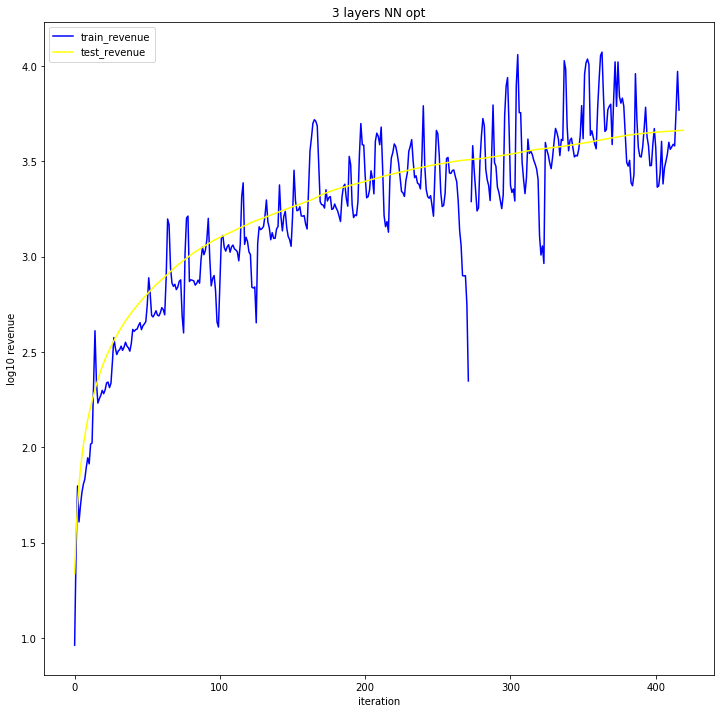

In [24]:
fig = plt.figure(figsize=(12, 12))
plt.title('3 layers NN opt')
plt.xlabel('iteration')
plt.ylabel('log10 revenue')
plt.plot(np.log10(train_losses),color = 'blue', label='train_revenue')
plt.plot(np.log10(test_losses), color= 'yellow', label='test_revenue' )
plt.legend()
plt.show()

## NN on multiple prices

# Conclusion on trained result:

For optimize over one price, we got the optimized result of revenue 55384.5, corresponding predicted demand around 143 and price as 387.63. 

This method is proved to be fast, only took about 1 minute to train over the whole neural network, whicle flexible in terms of able to train on more prices only need to adjust the parameter setting for the second neural networ 'p_f, p_sub and p_t'

# Next Step

- Check focal product price manually;


- Check the Focal Product Elasticity
- Check the Cross Price Elasticity
- Check the Optimization algorithm

- Try optimize over more price, other competitor prices in other columns (need to adjust columns)


## Defination of Price Elasticity:

Price Elasticity of Demand = :

change in Quantity Demanded% / Change in Price%. 

If a small change in price is accompanied by a large change in quantity demanded, the product is said to be elastic (or responsive to price changes). On the other hand, a product is deemed inelastic if a large change in price is accompanied by a small amount of change in quantity demanded.

Checking with calculations:

In [47]:
def get_elasticity(tr_name= 'NN Elasticity Train Result.csv', te_name= 'NN Elasticity Test Result.csv'):
    '''
    function for getting elasticity and store in csv file
    Args:
        tr_name:  train save file name, default 'NN Elasticity Train Result.csv'
        te_name:  test save file name, default 'NN Elasticity Test Result.csv'
    
    Returns:
        train_elasticity: train elasticity
        test_elasticity:  test elasticity
        
    
    Usecase:
        tr_ela, te_ela = get_elasticity(tr_name= 'NN Elasticity Train Result.csv', te_name= 'NN Elasticity Test Result.csv')
        tr_ela.head()
        
        
    '''
    W1_1 = paras[0]
    W1_2_1 = paras[1][0, :].reshape((1, 79))
    W1_2_2 = paras[1][1:, :]
    b1 = paras[2]
    W2_1_1 = paras[3][0, :]
    W2_1_2 = paras[3][1:, :]
    W2_2 = paras[4]
    b2 = paras[5]

    def sigmoid(x):
        return (1 / (1 + np.exp(-x)))

    def demand_fun(p_f, p_t, p_sub):
        p1 = np.matmul(sigmoid(np.matmul(p_f, W1_2_1) + np.matmul(p_t, W1_2_2) + np.matmul(p_sub, W1_1)+b1), W2_2)
        p2 = np.matmul(p_f, W2_1_1).reshape((len(p_f), 1)) 
        p3 = np.matmul(p_t, W2_1_2)+b2
        D = p1 + p2 + p3
        return D
    
    #train
    p_f_train = tv_train.iloc[:, 3].values.reshape((len(tv_train),1))
    p_t_train = np.concatenate((tv_train.iloc[:, 4:11].values, tv_train.iloc[:, 14:67].values), 1).astype(float)
    p_sub_train = tv_train.iloc[:, 66:84].values.astype(float)
    #test
    p_f_test = tv_test.iloc[:, 3].values.reshape((len(tv_test),1))
    p_t_test = np.concatenate((tv_test.iloc[:, 4:11].values, tv_test.iloc[:, 14:67].values), 1).astype(float)
    p_sub_test = tv_test.iloc[:, 66:84].values.astype(float)
    #cal train
    D_train = demand_fun(p_f_train, p_t_train, p_sub_train)
    p_f_train = p_f_train*1.1
    new_D_train = demand_fun(p_f_train, p_t_train, p_sub_train)
    #cal test
    D_test = demand_fun(p_f_test, p_t_test, p_sub_test)
    p_f_test = p_f_test*1.1
    new_D_test = demand_fun(p_f_test, p_t_test, p_sub_test)

    #save result to train excel file
    tr_result = pd.DataFrame(columns =['Price', 'Price10', 'True Sales', 'Pred Demand', 'Approx Pred Demand', 'New Pred Demand', 'Approx New Pred Demand', 'Elasticity'])
    tr_result['Price'] = tv_train.iloc[:, 3].values
    tr_result['Price10'] = tv_train.iloc[:, 3].values*1.1
    tr_result['True Sales'] = tv_train.iloc[:, 2].values
    tr_result['Pred Demand'] = D_train
    tr_result['Approx Pred Demand'] = list(map(int, np.round(D_train)))
    tr_result['New Pred Demand'] = new_D_train
    tr_result['Approx New Pred Demand'] = list(map(int, np.round(new_D_train)))
    tr_result['Elasticity'] = ((new_D_train-D_train)/D_train)/0.1
    tr_result.to_csv(tr_name)
    
    #save result to excel file
    te_result = pd.DataFrame(columns =['Price', 'Price10', 'True Sales', 'Pred Demand', 'Approx Pred Demand', 'New Pred Demand', 'Approx New Pred Demand', 'Elasticity'])
    te_result['Price'] = tv_test.iloc[:, 3].values
    te_result['Price10'] = tv_test.iloc[:, 3].values*1.1
    te_result['True Sales'] = tv_test.iloc[:, 2].values
    te_result['Pred Demand'] = D_test
    te_result['Approx Pred Demand'] = list(map(int, np.round(D_test)))
    te_result['New Pred Demand'] = new_D_test
    te_result['Approx New Pred Demand'] = list(map(int, np.round(new_D_test)))
    te_result['Elasticity'] = ((new_D_test-D_test)/D_test)/0.1
    te_result.to_csv(te_name)
    
    print('===== Finished !! ===== ')
    return tr_result, te_result

tr_ela, te_ela = get_elasticity(tr_name= 'NN Elasticity Train Result.csv', te_name= 'NN Elasticity Test Result.csv')
tr_ela.head()

===== Finished !! ===== 


,Price,Price10,True Sales,Pred Demand,Approx Pred Demand,New Pred Demand,Approx New Pred Demand,Elasticity
0,2626.27000,2888.897000,2,-5.652947,-6,-7.201821,-7,2.739941
1,2651.69398,2916.863378,6,-4.996403,-5,-6.560271,-7,3.129989
2,2774.57500,3052.032500,5,-2.200697,-2,-3.837036,-4,7.435548
3,2795.76000,3075.336000,6,-3.593950,-4,-5.242783,-5,4.587802
4,2795.76000,3075.336000,2,-3.159524,-3,-4.808357,-5,5.218612


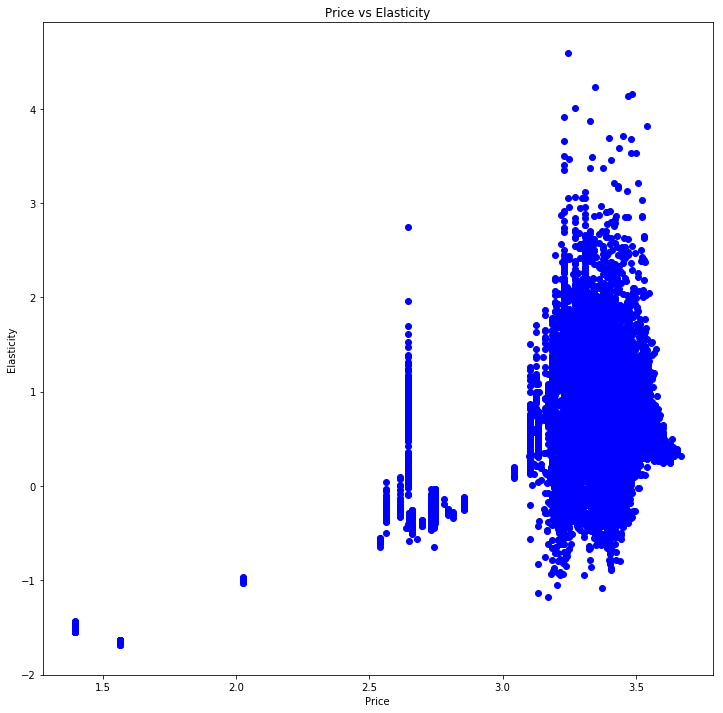

In [65]:
x=np.log10(np.abs(tr_ela.Price.values))
y= np.log10(np.abs(tr_ela.Elasticity.values))
plt.figure(figsize=(12,12))
plt.title('Price vs Elasticity')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.scatter(x, y, color='blue')
#plt.ylim(0, 40)
plt.show()

Check
1. check NN with Yasaman result
2. divide price;
2. try LBFGS on NN;
3. 

## Check the NN optimization algorith and LBFGS algorithm

An L-BFGS solver is a true second order method in that it estimates the curvature of the parameter space via an approximation of the Hessian. So if your parameter space has plenty of long, nearly-flat valleys then L-BFGS would likely perform well. It has the downside of additional costs in performing a rank-two update to the Hessian approximation at every step. While this is reasonably fast, it does begin to add up, particularly as the input space grows. This may account for the fact that ADAM outperforms L-BFGS for you as you get more data.

ADAM is a first order method that attempts to compensate for the fact that it doesn't estimate the curvature by adapting the step-size in every dimension. In some sense, this is similar to constructing a diagonal Hessian at every step, but they do it cleverly by simply using past gradients. In this way it is still a first order method, though it has the benefit of acting as though it is second order. The estimate is cruder than that of the L-BFGS in that it is only along each dimension and doesn't account for what would be the off-diagonals in the Hessian. If your Hessian is nearly singular then these off-diagonals may play an important ro^le in the curvature and ADAM is likely to underperform relative the BFGS.

In [19]:
# https://www.tensorflow.org/api_docs/python/tf/contrib/opt/ScipyOptimizerInterface
# https://stackoverflow.com/questions/50988466/using-l-bfgs-optimizer-with-tensorflow-estimator-api
# https://stackoverflow.com/questions/47385084/do-tensorflow-scipyoptimizerinterface-l-bfgs-and-others-work-with-auto-differe
# https://stackoverflow.com/questions/33720645/why-is-this-tensorflow-implementation-vastly-less-successful-than-matlabs-nn
#trial

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import time 
from tensorflow.contrib.opt import ScipyOptimizerInterface 

#optimize the loss funciton by adding negative sign
start_time= time.time()
tf.reset_default_graph()

p_f = tf.get_variable('p_f', shape=(1, 1)) #corresponding index 0 in 

W1_1 = tf.constant(paras[0], dtype=tf.float32, name='W1_1' )
W1_2_1 = tf.constant(paras[1][0, :], dtype=tf.float32, shape=[1, 79], name='W1_2_1')
W1_2_2 = tf.constant(paras[1][1:, :], dtype=tf.float32, name='W1_2_2')
b1 = tf.constant(paras[2], dtype=tf.float32, name='b1' )
W2_1_1 = tf.constant(paras[3][0, :], dtype=tf.float32, shape=[1, 1], name='W1_2_1')
W2_1_2 = tf.constant(paras[3][1:, :], dtype=tf.float32, name='W1_2_2')
W2_2 = tf.constant(paras[4], dtype=tf.float32, name='W2_2' )
b2 = tf.constant(paras[5], dtype=tf.float32, name='b2' )

p_sub =  tf.placeholder(shape=(None, 18), dtype=tf.float32 , name="p_sub")
p_t =  tf.placeholder(shape=(None, 60), dtype=tf.float32, name= 'p_t') #the other part except for the price

#D = tf.matmul(tf.nn.sigmoid(tf.matmul(p_f, W1_2_1)+ tf.matmul(p_t, W1_2_2) + tf.matmul(p_sub, W1_1)+b1), W2_2)+tf.matmul(p_f, W2_1_1)+ tf.matmul(p_t, W2_1_2)+b2
D = tf.matmul(tf.nn.sigmoid(tf.matmul(p_f, W1_2_1)+ tf.matmul(p_t, W1_2_2) + tf.matmul(p_sub, W1_1)+b1), W2_2)+tf.matmul(p_f, W2_1_1)+ tf.matmul(p_t, W2_1_2)+b2
    
p_loss = tf.reduce_mean(-p_f*D) #self defined loss

###parameters
learning_rate = 0.5 #lbfgs optimization
optimizer = tf.contrib.opt.ScipyOptimizerInterface(p_loss, var_to_bounds={p_f: (np.min(new_tv_info.iloc[:, 3]), np.max(new_tv_info.iloc[:, 3]))}, method='L-BFGS-B', options={'maxiter': 1000})

with tf.Session() as sess:
    init = tf.global_variables_initializer() 
    x1_train = tv_train.iloc[:, 66:84].values 
    x1_test = tv_test.iloc[:, 66:84].values
    x2_train = np.concatenate((tv_train.iloc[:, 4:11].values, tv_train.iloc[:, 14:67].values), 1) 
    x2_test = np.concatenate((tv_test.iloc[:, 4:11].values, tv_test.iloc[:, 14:67].values), 1) 
    sess.run(init)
    optimizer.minimize(sess, feed_dict={p_sub: x1_train, p_t: x2_train}) 
    ret=sess.run(p_f)
    print(ret)
     
end_time=time.time()
print('trained total elasped time:', end_time-start_time)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -14167.371094
  Number of iterations: 2
  Number of functions evaluations: 3
[[ 4660.16992188]]
trained total elasped time: 0.43399906158447266


In [64]:
import time 
from tensorflow.contrib.opt import ScipyOptimizerInterface 

#optimize the loss funciton by adding negative sign
start_time= time.time()
tf.reset_default_graph()

p_f = tf.get_variable('p_f', shape=(50, 1)) #corresponding index 0 in 

W1_1 = tf.constant(paras[0], dtype=tf.float32, name='W1_1' )
W1_2_1 = tf.constant(paras[1][0, :], dtype=tf.float32, shape=[1, 79], name='W1_2_1')
W1_2_2 = tf.constant(paras[1][1:, :], dtype=tf.float32, name='W1_2_2')
b1 = tf.constant(paras[2], dtype=tf.float32, name='b1' )
W2_1_1 = tf.constant(paras[3][0, :], dtype=tf.float32, shape=[1, 1], name='W1_2_1')
W2_1_2 = tf.constant(paras[3][1:, :], dtype=tf.float32, name='W1_2_2')
W2_2 = tf.constant(paras[4], dtype=tf.float32, name='W2_2' )
b2 = tf.constant(paras[5], dtype=tf.float32, name='b2' )

p_sub =  tf.placeholder(shape=(None, 18), dtype=tf.float32 , name="p_sub")
p_t =  tf.placeholder(shape=(None, 60), dtype=tf.float32, name= 'p_t') 

D = tf.matmul(tf.nn.sigmoid(tf.matmul(p_f, W1_2_1)+ tf.matmul(p_t, W1_2_2) + tf.matmul(p_sub, W1_1)+b1), W2_2)+tf.matmul(p_f, W2_1_1)+ tf.matmul(p_t, W2_1_2)+b2
#D = tf.nn.sigmoid(tf.matmul(p_f, W1_2_1)+ tf.matmul(p_t, W1_2_2) +tf.matmul(p_sub, W1_1) + b1)

p_loss = tf.reduce_mean(-p_f*D) #self defined loss

###parameters
learning_rate = 0.5
optimizer = tf.contrib.opt.ScipyOptimizerInterface(p_loss, var_to_bounds={p_f: (np.min(new_tv_info.iloc[:, 3]), np.max(new_tv_info.iloc[:, 3]))}, method='L-BFGS-B', options={'maxiter': 1000} )
pf = [] 
p_losses = []

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    for step in range(493):
        #parameters 
        try:
            x1_train = new_tv_info.iloc[step*batch_size:step*batch_size+batch_size, 66:84].values 
            #x1_test = tv_test.iloc[:, 66:84].values
            x2_train = np.concatenate((new_tv_info.iloc[step*batch_size:step*batch_size+batch_size, 4:11].values, new_tv_info.iloc[step*batch_size:step*batch_size+batch_size, 14:67].values), 1) 
            #x2_test = np.concatenate((tv_test.iloc[:, 4:11].values, tv_test.iloc[:, 14:67].values), 1) 
            sess.run(init)
            optimizer.minimize(sess, feed_dict={p_sub: x1_train, p_t: x2_train}) 
            res = sess.run([p_f, p_loss], feed_dict={p_sub:x1_train, p_t: x2_train})
            pf.append(res[0].flatten())
            p_losses.append(-res[1])
        except:
            pass
        
pf=np.array(pf).ravel()
end_time=time.time()
print('total predicted price',len(pf), 'trained total elasped time:', end_time-start_time)
pf.append(res[0].flatten())
p_losses.append(-res[1])
opt_pf = pd.DataFrame({'opt_pf': pf})
tr_col_names = list(tr_ela.columns)
tr_ela = pd.concat([tr_ela, opt_pf], ignore_index=True, axis=1)
tr_ela.columns =  tr_col_names + ['opt_pf']
tr_ela.to_csv('NN Elasticity Train Result.csv')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -13727.675781
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -14609.488281
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -31326.931641
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -12371.170898
  Number of iterations: 3
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -5084.68

  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -4961.050781
  Number of iterations: 3
  Number of functions evaluations: 18
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -4972.261719
  Number of iterations: 3
  Number of functions evaluations: 18
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -5265.748047
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -5428.893555
  Number of iterations: 3
  Number of functions evaluations: 20
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  O

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -29291.072266
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -10266.373047
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -6508.205078
  Number of iterations: 3
  Number of functions evaluations: 17
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -6317.018066
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -5934.580

  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -1348.237061
  Number of iterations: 3
  Number of functions evaluations: 20
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -1208.809814
  Number of iterations: 3
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -2377.765625
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -8661.670898
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective functio

  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -12380.230469
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -13298.016602
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -7999.903320
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -6486.035156
  Number of iterations: 3
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
 

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -65771.226562
  Number of iterations: 3
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -46956.468750
  Number of iterations: 3
  Number of functions evaluations: 14
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -53951.253906
  Number of iterations: 3
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -55299.863281
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -18940.2

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -29151.806641
  Number of iterations: 3
  Number of functions evaluations: 18
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -22591.193359
  Number of iterations: 3
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -17990.742188
  Number of iterations: 3
  Number of functions evaluations: 19
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -9307.791992
  Number of iterations: 3
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -6013.037

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -15471.182617
  Number of iterations: 3
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -13676.325195
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -16473.828125
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -12872.429688
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -7948.0

  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -4908.870605
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -3363.959473
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -3436.985107
  Number of iterations: 3
  Number of functions evaluations: 13
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -2685.575684
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -37525.507812
  Number of iterations: 3
  Number of functions evaluations: 20
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -42852.203125
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -48784.828125
  Number of iterations: 3
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -48157.984375
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -5604.87

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -7108.067383
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -8564.022461
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -16252.433594
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -11859.452148
  Number of iterations: 3
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -11839.01

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -66665.687500
  Number of iterations: 3
  Number of functions evaluations: 18
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -57994.039062
  Number of iterations: 3
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -40970.878906
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -30203.509766
  Number of iterations: 4
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -8753.1

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -7826.908691
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -5565.968750
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -4612.407715
  Number of iterations: 3
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -4489.321777
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -7509.28076

AttributeError: 'numpy.ndarray' object has no attribute 'append'

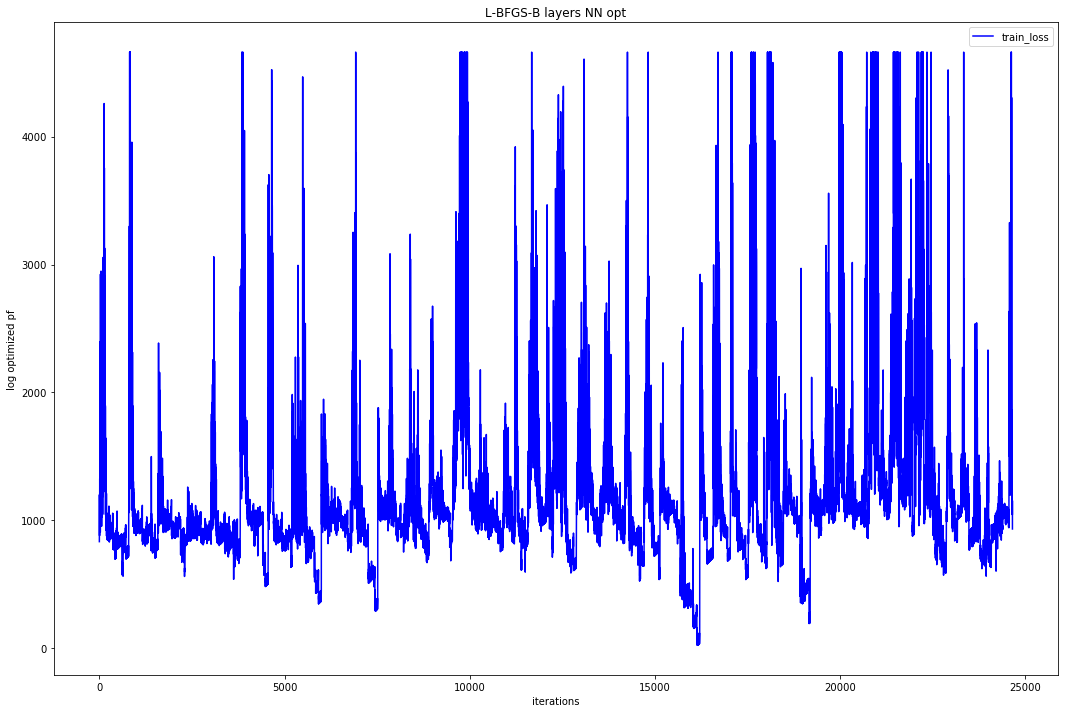

In [70]:
fig = plt.figure(figsize=(18, 12))
plt.title('L-BFGS-B layers NN opt')
plt.xlabel('iterations')
plt.ylabel('log optimized pf')
plt.plot(pf, color = 'blue', label='train_loss')
plt.legend()
plt.show()

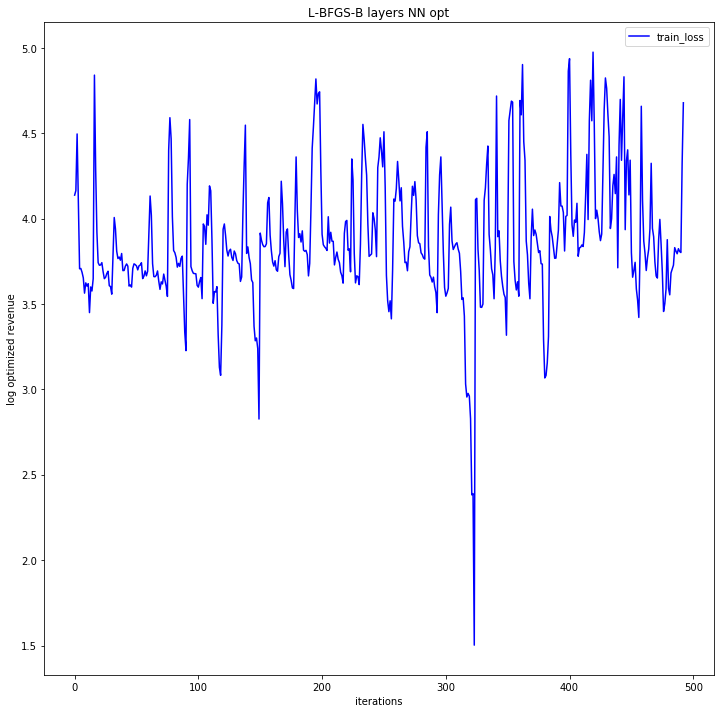

In [67]:
fig = plt.figure(figsize=(12, 12))
plt.title('L-BFGS-B layers NN opt')
plt.xlabel('iterations')
plt.ylabel('log optimized revenue')
plt.plot(np.log10(p_losses), color = 'blue', label='train_loss')
plt.legend()
plt.show()

In [71]:
all_result = pd.concat([tr_result, te_result], ignore_index=True)
all_result.head()
price = pd.DataFrame({'opt_price': pf})
col_names = np.hstack((list(all_result.columns), ['opt_price']))
all_result = pd.concat([all_result, price], ignore_index=True, axis=1)
all_result.columns= col_names
all_result.to_csv('NN Elasticity All Result.csv')
all_result.head()

NameError: name 'tr_result' is not defined

Next Step:

1. report on result so far;
2. multiple prices;
3. check lbfgs opt prices and send result to Yasaman;
4. construct the optimization function of multiple products, goal is for all 49 products. 

# More prices optimization

## using NN

In [43]:
import time 

#optimize the loss funciton by adding negative sign
start_time= time.time()
tf.reset_default_graph()
price1 = tf.get_variable('price1', shape=(1, 1)) #corresponding index 0 in 
price2 = tf.get_variable('price2', shape=(1, 9))  

W1_1_1 = tf.constant(paras[0][:9,:], dtype=tf.float32, name='W1_1_1' )
W1_1_2 =  tf.constant(paras[0][9:,:], dtype=tf.float32, name='W1_1_2' )
W1_2_1 = tf.constant(paras[1][0, :], dtype=tf.float32, shape=[1, 79], name='W1_2_1')
W1_2_2 = tf.constant(paras[1][1:, :], dtype=tf.float32, name='W1_2_2')
b1 = tf.constant(paras[2], dtype=tf.float32, name='b1' )
W2_1_1 = tf.constant(paras[3][0, :], dtype=tf.float32, shape=[1, 1], name='W1_2_1')
W2_1_2 = tf.constant(paras[3][1:, :], dtype=tf.float32, name='W1_2_2')
W2_2 = tf.constant(paras[4], dtype=tf.float32, name='W2_2' )
b2 = tf.constant(paras[5], dtype=tf.float32, name='b2' )

p_sub =  tf.placeholder(shape=(None, 9), dtype=tf.float32)
p_t =  tf.placeholder(shape=(None, 60), dtype=tf.float32) #the other part except for the price

D = tf.matmul(tf.nn.sigmoid(tf.matmul(price1, W1_2_1)+ tf.matmul(p_t, W1_2_2) + tf.matmul(price2, W1_1_1)+ tf.matmul(p_sub, W1_1_2)+b1), W2_2)+tf.matmul(price1, W2_1_1)+ tf.matmul(p_t, W2_1_2)+b2
p_loss = tf.reduce_mean(-price1*D) #self defined loss

###parameters
batch_size = 50
learning_rate = 0.5
trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)  #why not SGD??
gradients = trainer.compute_gradients(p_loss)
optimizer = trainer.apply_gradients(gradients) #??
#optimizer = tf.contrib.opt.ScipyOptimizerInterface(p_loss, method='L-BFGS-B', options={'maxiter': 1000})

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(419):
        #parameters 
        x1_train = tv_train.iloc[step*batch_size:step*batch_size+batch_size, 75:84].values 
        x1_test = tv_test.iloc[:, 75:84].values
        x2_train = np.concatenate((tv_train.iloc[step*batch_size:step*batch_size+batch_size, 4:11].values, tv_train.iloc[step*batch_size:step*batch_size+batch_size, 14:67].values), 1) 
        x2_test = np.concatenate((tv_test.iloc[:, 4:11].values, tv_test.iloc[:, 14:67].values), 1) 
        
        loss_tr, _ = sess.run([p_loss, optimizer], feed_dict={p_sub: x1_train, p_t: x2_train})
        _test_loss = sess.run([p_loss], feed_dict={p_sub: x1_test, p_t: x2_test})
              
        # predict
        D_pred_tr = sess.run([D], feed_dict={p_sub:x1_train, p_t: x2_train})
        D_pred_te = sess.run([D], feed_dict={p_sub:x1_test, p_t: x2_test})
        p1_pred_tr = sess.run([price1], feed_dict={p_sub:x1_train, p_t: x2_train})
        p1_pred_te = sess.run([price1], feed_dict={p_sub:x1_test, p_t: x2_test})
        p2_pred_tr = sess.run([price2], feed_dict={p_sub:x1_train, p_t: x2_train})
        p2_pred_te = sess.run([price2], feed_dict={p_sub:x1_test, p_t: x2_test})
        
        if step % 200 == 0:
            print()
            #print("iter:%d, train_loss: %f, test_loss: %f"%(step, loss_tr,  _test_loss[0]))
            print("simulated train_revenue: %f, simulated test_revenue: %f"%(-loss_tr,  -_test_loss[0]))
            print('train D prediction parameters results:', D_pred_tr[0][0])
            print('test D prediction parameters results:', D_pred_te[0][0])
            print('train price1 focal product prediction parameters results:', p1_pred_tr[0][0])
            print('test price1 focal product prediction parameters results:', p1_pred_te[0][0])
            print('train price2 sub product prediction parameters results:', p2_pred_tr[0][0])
            print('test price2 sub product prediction parameters results:', p2_pred_te[0][0])
            print()
print('\n last test prediction parameters results:', step, -loss_tr,  -_test_loss[0], 
    '\n predicted mean demand and price for one batch', np.mean(D_pred_te[0]), pf_pred_te[0])

end_time=time.time()
print('trained total elasped time:', end_time-start_time)


simulated train_revenue: 6.520099, simulated test_revenue: 5.892707
train D prediction parameters results: [-0.55061346]
test D prediction parameters results: [ 2.98699307]
train price1 focal product prediction parameters results: [ 1.6397773]
test price1 focal product prediction parameters results: [ 1.6397773]
train price2 sub product prediction parameters results: [ 0.20566344  0.2764245   1.17547333 -0.34504586  0.04544291  0.70799279
 -0.35958651  0.5083406   0.54078305]
test price2 sub product prediction parameters results: [ 0.20566344  0.2764245   1.17547333 -0.34504586  0.04544291  0.70799279
 -0.35958651  0.5083406   0.54078305]


simulated train_revenue: 640.548340, simulated test_revenue: 201.727158
train D prediction parameters results: [ 16.99229622]
test D prediction parameters results: [ 2.96428204]
train price1 focal product prediction parameters results: [ 56.48276901]
test price1 focal product prediction parameters results: [ 56.48276901]
train price2 sub product pr

## using LBFGS

In [69]:
import time 
from tensorflow.contrib.opt import ScipyOptimizerInterface 

#optimize the loss funciton by adding negative sign
start_time= time.time()
tf.reset_default_graph()

#p_f = tf.get_variable('p_f', shape=(50, 1)) #corresponding index 0 in 
price1 = tf.get_variable('price1', shape=(50, 1)) #corresponding index 0 in 
price2 = tf.get_variable('price2', shape=(50, 9))  

W1_1_1 = tf.constant(paras[0][:9,:], dtype=tf.float32, name='W1_1_1' )
W1_1_2 =  tf.constant(paras[0][9:,:], dtype=tf.float32, name='W1_1_2' )
W1_2_1 = tf.constant(paras[1][0, :], dtype=tf.float32, shape=[1, 79], name='W1_2_1')
W1_2_2 = tf.constant(paras[1][1:, :], dtype=tf.float32, name='W1_2_2')
b1 = tf.constant(paras[2], dtype=tf.float32, name='b1' )
W2_1_1 = tf.constant(paras[3][0, :], dtype=tf.float32, shape=[1, 1], name='W2_1_1')
W2_1_2 = tf.constant(paras[3][1:, :], dtype=tf.float32, name='W2_1_2')
W2_2 = tf.constant(paras[4], dtype=tf.float32, name='W2_2' )
b2 = tf.constant(paras[5], dtype=tf.float32, name='b2' )

p_sub =  tf.placeholder(shape=(None, 9), dtype=tf.float32)
p_t =  tf.placeholder(shape=(None, 60), dtype=tf.float32) #the other part except for the price


D = tf.matmul(tf.nn.sigmoid(tf.matmul(price1, W1_2_1)+ tf.matmul(p_t, W1_2_2) + tf.matmul(price2, W1_1_1)+ tf.matmul(p_sub, W1_1_2)+b1), W2_2)+tf.matmul(price1, W2_1_1)+ tf.matmul(p_t, W2_1_2)+b2
p_loss = tf.reduce_mean(-price1*D) #self defined loss

###parameters
learning_rate = 0.5
optimizer = tf.contrib.opt.ScipyOptimizerInterface(p_loss, var_to_bounds={price1: (np.min(new_tv_info.iloc[:, 3]), np.max(new_tv_info.iloc[:, 3]))}, method='L-BFGS-B', options={'maxiter': 1000} )
pf = [] 
psub_res= np.zeros((len(new_tv_info), 9))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    for step in range(493): #493
        #parameters 
            x1_train = new_tv_info.iloc[step*batch_size:step*batch_size+batch_size, 75:84].values 
            #x1_test = tv_test.iloc[:, 66:84].values
            x2_train = np.concatenate((new_tv_info.iloc[step*batch_size:step*batch_size+batch_size, 4:11].values, new_tv_info.iloc[step*batch_size:step*batch_size+batch_size, 14:67].values), 1) 
            #x2_test = np.concatenate((tv_test.iloc[:, 4:11].values, tv_test.iloc[:, 14:67].values), 1) 
            sess.run(init)
            optimizer.minimize(sess, feed_dict={p_sub: x1_train, p_t: x2_train}) 
            res = sess.run(price1)
            pf.append(res.flatten())
            res = sess.run(price2)
            for j in range(len(res)):
                for i in range(9):
                    psub_res[50*step+j, i] = res[j][i]
            #res=sess.run(price2)
            
       
        
pf=np.array(pf).ravel()
end_time=time.time()
print('total predicted price',len(pf), 'trained total elasped time:', end_time-start_time)
opt_pf = pd.DataFrame({'opt_pf': pf})
opt_psub = pd.DataFrame({'opt_psub1': psub_res[:, 0],'opt_psub2': psub_res[:, 1], 'opt_psub3': psub_res[:, 2],'opt_psub4': psub_res[:, 3],
                        'opt_psub5': psub_res[:, 4],'opt_psub6': psub_res[:, 5],'opt_psub7': psub_res[:, 6],'opt_psub8': psub_res[:, 7],'opt_psub9': psub_res[:, 8]})
tr_col_names = list(tr_ela.columns)
tr_ela = pd.concat([tr_ela, opt_pf], ignore_index=True, axis=1)

tr_ela = pd.concat([tr_ela, opt_psub], ignore_index=True, axis=1)
tr_ela.columns =  tr_col_names + ['opt_pf', 'opt_psub1', 'opt_psub2','opt_psub3','opt_psub4', 'opt_psub5','opt_psub6','opt_psub7','opt_psub8','opt_psub9']

tr_ela.to_csv('NN Elasticity Train Result_LBFGS.csv')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -83532.718750
  Number of iterations: 11
  Number of functions evaluations: 18
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -24606.867188
  Number of iterations: 5
  Number of functions evaluations: 7
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -57726.898438
  Number of iterations: 4
  Number of functions evaluations: 6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -22734.474609
  Number of iterations: 10
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -9537

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -89822.890625
  Number of iterations: 4
  Number of functions evaluations: 7
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -87899.546875
  Number of iterations: 18
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -63451.769531
  Number of iterations: 50
  Number of functions evaluations: 113
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -92026.351562
  Number of iterations: 17
  Number of functions evaluations: 32
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -91

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -53496.320312
  Number of iterations: 4
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -20580.894531
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -12747.028320
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -13175.566406
  Number of iterations: 3
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -14350.

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -93751.656250
  Number of iterations: 40
  Number of functions evaluations: 115
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -76385.546875
  Number of iterations: 227
  Number of functions evaluations: 484
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -58432.558594
  Number of iterations: 135
  Number of functions evaluations: 288
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -31463.033203
  Number of iterations: 110
  Number of functions evaluations: 242
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function valu

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -47174.585938
  Number of iterations: 439
  Number of functions evaluations: 831
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -19635.230469
  Number of iterations: 39
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -45641.558594
  Number of iterations: 237
  Number of functions evaluations: 556
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -18117.400391
  Number of iterations: 41
  Number of functions evaluations: 97
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value:

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -95993.726562
  Number of iterations: 24
  Number of functions evaluations: 59
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -64326.804688
  Number of iterations: 6
  Number of functions evaluations: 10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -72724.773438
  Number of iterations: 6
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -77231.828125
  Number of iterations: 3
  Number of functions evaluations: 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -3475

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -53214.800781
  Number of iterations: 20
  Number of functions evaluations: 81
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -43312.296875
  Number of iterations: 5
  Number of functions evaluations: 10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -33452.539062
  Number of iterations: 14
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -39565.906250
  Number of iterations: 159
  Number of functions evaluations: 343
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -8

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -41850.031250
  Number of iterations: 2
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -31625.914062
  Number of iterations: 3
  Number of functions evaluations: 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -34196.351562
  Number of iterations: 3
  Number of functions evaluations: 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -28083.525391
  Number of iterations: 2
  Number of functions evaluations: 3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -18912.

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -83407.031250
  Number of iterations: 4
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -24123.244141
  Number of iterations: 29
  Number of functions evaluations: 61
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -46955.378906
  Number of iterations: 149
  Number of functions evaluations: 329
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -77328.867188
  Number of iterations: 122
  Number of functions evaluations: 318
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value:

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -69422.898438
  Number of iterations: 79
  Number of functions evaluations: 128
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -65153.125000
  Number of iterations: 6
  Number of functions evaluations: 8
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -80006.320312
  Number of iterations: 6
  Number of functions evaluations: 10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -84049.367188
  Number of iterations: 7
  Number of functions evaluations: 33
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -1398

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -89342.367188
  Number of iterations: 55
  Number of functions evaluations: 122
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -91598.890625
  Number of iterations: 15
  Number of functions evaluations: 33
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -32123.859375
  Number of iterations: 8
  Number of functions evaluations: 36
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -17428.156250
  Number of iterations: 10
  Number of functions evaluations: 11
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -4

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -99024.351562
  Number of iterations: 10
  Number of functions evaluations: 30
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -88281.500000
  Number of iterations: 3
  Number of functions evaluations: 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -55966.308594
  Number of iterations: 12
  Number of functions evaluations: 20
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -44803.378906
  Number of iterations: 73
  Number of functions evaluations: 172
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -1

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -9787.294922
  Number of iterations: 95
  Number of functions evaluations: 163
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -88832.718750
  Number of iterations: 29
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -88719.789062
  Number of iterations: 5
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -82751.070312
  Number of iterations: 21
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -37